# Comparing BDT and NN Statistics

In [1]:
import pickle
import numpy as np
import pandas as pd
import torch as th
from matplotlib import pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score
from nn_classes import *

### Load the Data

In [2]:
#trainset = CollisionDataset("ttH_hadT_cut_train.csv", header=0, target_col=0, index_col=0)
#testset = CollisionDataset("ttH_hadT_cut_test.csv", header=0, target_col=0, index_col=0, scaler=trainset.scaler)

raw_trainset = CollisionDataset("ttH_hadT_cut_raw_train.csv", header=0, target_col=0, index_col=0)
raw_testset = CollisionDataset("ttH_hadT_cut_raw_test.csv", header=0, target_col=0, index_col=0, scaler=raw_trainset.scaler)

In [20]:
raw_trainset.scaler.mean_, raw_trainset.scaler.scale_ # Feature means, std dev

(array([ 6.87468347e+01,  7.58109045e-04,  3.08424283e-03,  1.01456802e+01,
         7.37616768e-03, -2.75248691e-02, -8.29630439e-02,  3.30091133e-02,
         6.53981211e-01,  6.11728080e-01,  6.86166528e+01,  1.47885047e-03,
        -5.08514581e-03,  1.05728198e+01,  6.63662604e-03,  1.93718354e-01,
         6.03991239e-03,  1.80917415e-01,  6.03576471e-01,  5.76912597e-01,
         7.92487489e+01,  3.78752704e-04, -5.62277807e-03,  1.18420800e+01,
         6.75245999e-03,  6.33178097e-01,  4.04049734e-02,  1.27934925e-01,
         1.98158822e-01,  5.26623707e-01]),
 array([44.59332316,  1.00947689,  1.81404802,  5.62324991,  0.34653027,
         0.30292346,  0.27902078,  0.32030417,  0.51590614,  0.37531706,
        49.31193177,  1.06648738,  1.81406616,  6.61586785,  0.34028588,
         0.21872364,  0.06415272,  0.13027073,  0.28017698,  0.36247352,
        53.9928916 ,  1.04218656,  1.81123307,  7.01009623,  0.32720164,
         0.33124976,  0.09066354,  0.13149438,  0.27972439,

In [3]:
#test_X = testset._X
#test_y = testset._y

#test5_X = testset.dataframe.loc[:, ["Top Mass", "(b, j2) mass", "(b, j3) mass", "Top Pt", "W ptDR"]]
#test5_y = test_y

raw_test_X = raw_testset._X
raw_test_y = raw_testset._y

#nn_testX = Variable(testset[:]['input']).float()
#nn_testy = Variable(testset[:]['target']).long().view(-1, 1)

raw_nn_testX = Variable(raw_testset[:]['input']).float()
raw_nn_testy = Variable(raw_testset[:]['target']).long().view(-1, 1)

### Load the BDTs

In [22]:
with open("bdt.pkl", 'rb') as f:
    bdt = pickle.load(f)
with open("bdt_eng5.pkl", 'rb') as f:
    bdt5 = pickle.load(f)
with open("basic_bdt.pkl", 'rb') as f: 
    bdt_basic = pickle.load(f)

### Load the Neural Nets

In [4]:
#input_dim = testset._X.shape[1]
raw_input_dim = raw_testset._X.shape[1]

#net = BinaryNet(input_dim)
#raw_net = BinaryNet(raw_input_dim)
#deep_net = DeepBinaryNet(raw_input_dim)
#deep_drop = DeepBinaryDropNet(raw_input_dim)
deep_reg = DeepBinaryRegNet(raw_input_dim)

#net.load_state_dict(th.load("neural_net.torch"))
#raw_net.load_state_dict(th.load("raw_neural_net.torch"))
#deep_net.load_state_dict(th.load("deep_basic_neural_net.torch"))
#deep_drop.load_state_dict(th.load("deep_basic_neural_net_drop.torch"))
deep_reg.load_state_dict(th.load("deep_basic_neural_net_reg2.torch"))

## Make Predictions/Discriminants

In [23]:
bdt_predicted = bdt.predict(test_X)
bdt_decision = bdt.decision_function(test_X)

bdt5_predicted = bdt5.predict(test5_X)
bdt5_decision = bdt5.decision_function(test5_X)

bdt_basic_predicted = bdt_basic.predict(raw_test_X)
bdt_basic_decision = bdt_basic.decision_function(raw_test_X)

In [5]:
discriminant_var = net(nn_testX)
discriminant = discriminant_var.data.numpy()
predicted = th.round(discriminant_var.data).long().numpy()
np_nn_testy = nn_testy.data.numpy()

In [6]:
raw_discriminant_var = raw_net(raw_nn_testX)
raw_discriminant = raw_discriminant_var.data.numpy()
raw_predicted = th.round(raw_discriminant_var.data).long().numpy()
np_raw_nn_testy = raw_nn_testy.data.numpy()

In [7]:
deep_discriminant_var = deep_net(raw_nn_testX)
deep_discriminant = deep_discriminant_var.data.numpy()
deep_predicted = th.round(deep_discriminant_var.data).long().numpy()

In [8]:
deep_drop_discriminant_var = deep_drop(raw_nn_testX)
deep_drop_discriminant = deep_drop_discriminant_var.data.numpy()
deep_drop_predicted = th.round(deep_drop_discriminant_var.data).long().numpy()

In [6]:
np_raw_nn_testy = raw_nn_testy.data.numpy()

In [5]:
deep_reg_discriminant_var = deep_reg(raw_nn_testX)
deep_reg_discriminant = deep_reg_discriminant_var.data.numpy()
deep_reg_predicted = th.round(deep_reg_discriminant_var.data).long().numpy()

## Generate Summary Statistics
Summary statistics will be calculated using the best cut for each model.
- Precision: The percent of predicted signal that are actually signal (prediction efficiency).
- Recall: The percent of actualy signal that is predicted signal (what percent of signal was identified).

In [7]:
def print_stats(discriminant, targets, n_steps=100):
    best_cut = 0
    best_score = -1
    for i in range(n_steps+1):
        cut = i*((discriminant.max() - discriminant.min())/n_steps) + discriminant.min()
        score = f1_score(targets, (discriminant >= cut).astype(np.int32))
        if score > best_score:
            best_score = score
            best_cut = cut
    print(classification_report(targets, (discriminant >= best_cut).astype(np.int32)))
    #print(confusion_matrix(targets, (discriminant >= best_cut).astype(np.int32)))
    print("Area Under Curve: {}".format(roc_auc_score(targets, discriminant)))

In [8]:
#print("Shallow Neural Net: All Features")
#print_stats(discriminant, np_nn_testy)
#print("\n\nShallow Neural Net: Basic Features")
#print_stats(raw_discriminant, np_raw_nn_testy)
#print("\n\nDeep Neural Net: Basic Features")
#print_stats(deep_discriminant, np_raw_nn_testy)
print("\n\nOptimized Deep Neural Net: Basic Features")
print_stats(deep_reg_discriminant, np_raw_nn_testy)



Optimized Deep Neural Net: Basic Features
             precision    recall  f1-score   support

          0       0.86      0.72      0.78    106365
          1       0.76      0.88      0.82    106365

avg / total       0.81      0.80      0.80    212730

Area Under Curve: 0.889614968077


In [24]:
print("BDT: All Features")
print_stats(bdt_decision, test_y)
print("\n\nBDT: 5 Eng Features")
print_stats(bdt5_decision, test5_y)
print("\n\nBDT: Basic Features")
print_stats(bdt_basic_decision, raw_test_y)

BDT: All Features
             precision    recall  f1-score   support

          0       0.85      0.76      0.80     85092
          1       0.78      0.87      0.82     85092

avg / total       0.82      0.81      0.81    170184

Area Under Curve: 0.898582290709


BDT: 5 Eng Features
             precision    recall  f1-score   support

          0       0.83      0.73      0.78     85092
          1       0.76      0.85      0.80     85092

avg / total       0.80      0.79      0.79    170184

Area Under Curve: 0.8769843106


BDT: Basic Features
             precision    recall  f1-score   support

          0       0.76      0.56      0.64     85092
          1       0.65      0.82      0.72     85092

avg / total       0.70      0.69      0.68    170184

Area Under Curve: 0.781664676878


/home/drnevich/miniconda3/envs/ROOT/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Generate ROC Curves

In [13]:
def overlay_roc_curves(experiments, title=""):
    fig, ax = plt.subplots()
    for exp in experiments:
        roc_points = roc_curve(exp['targets'], exp['discriminant'])
        plt.plot(roc_points[0], roc_points[1], label=exp.get("label"))
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title("ROC Curves {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

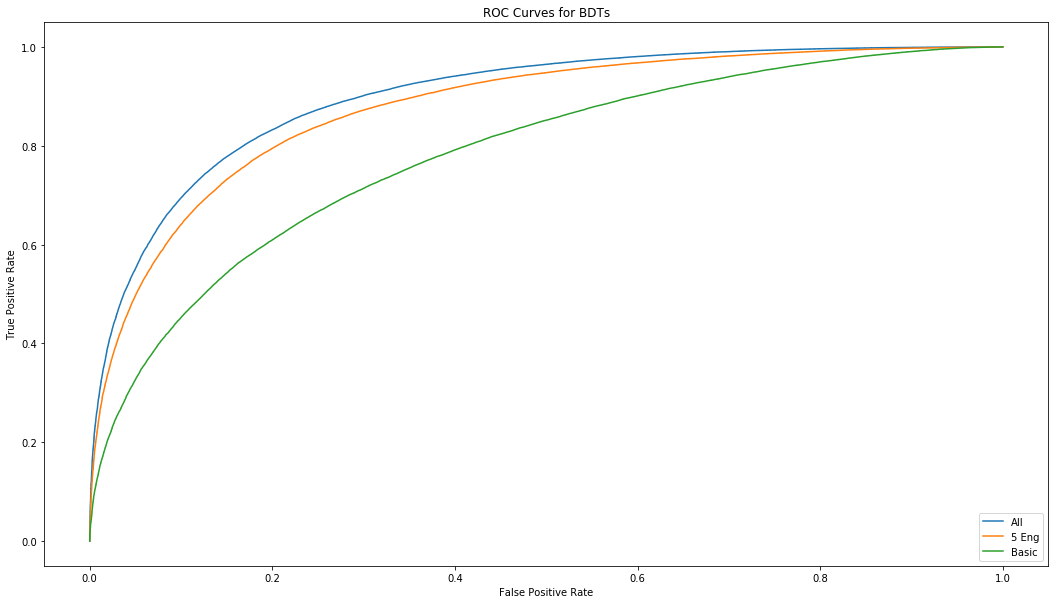

In [25]:
overlay_roc_curves([{'discriminant': bdt_decision,
                    'targets': test_y,
                    'label': "All"},
                    {'discriminant': bdt5_decision,
                     'targets': test5_y,
                     'label': "5 Eng"},
                   {'discriminant': bdt_basic_decision,
                     'targets': raw_test_y,
                     'label': "Basic"}])

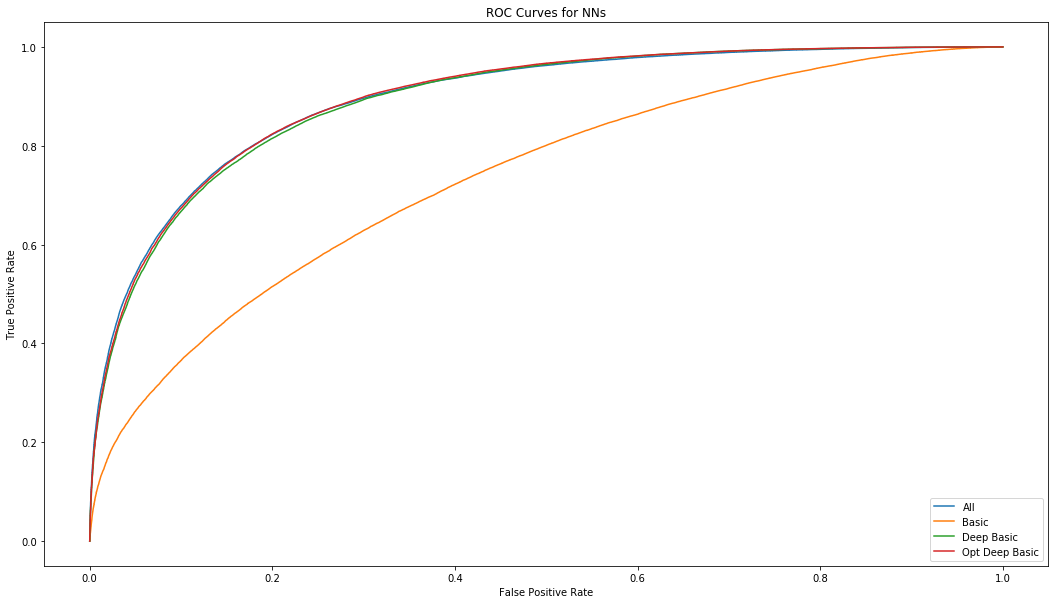

In [14]:
overlay_roc_curves([{'discriminant': discriminant,
                    'targets': np_nn_testy,
                    'label': "All"},
                    {'discriminant': raw_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Basic"},
                    {'discriminant': deep_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Deep Basic"},
                   {'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="NNs")

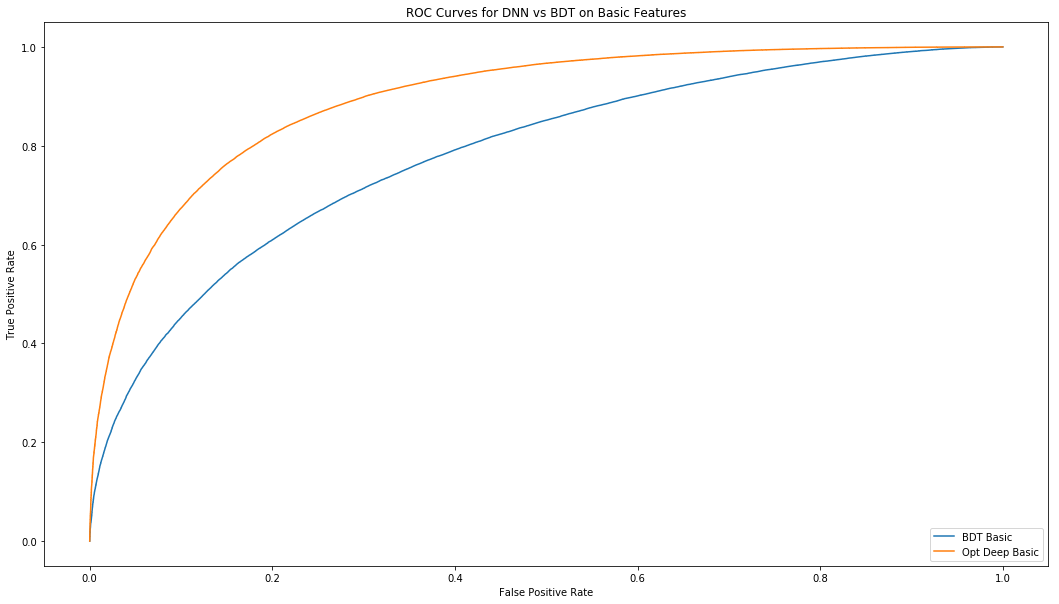

In [26]:
overlay_roc_curves([{'discriminant': bdt_basic_decision,
                    'targets': raw_test_y,
                    'label': "BDT Basic"},
                    {'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="DNN vs BDT on Basic Features")

## Plot Distributions

In [15]:
def plot_distro(experiments, title="NN"):
    fig, ax = plt.subplots()
    for exp in experiments:
        dsignal, dbkgd = exp['discriminant'][(exp['targets'] == 1)], exp['discriminant'][(exp['targets'] == 0)]
    plt.hist(dsignal, alpha=0.5, label="Signal")
    plt.hist(dbkgd, alpha=0.5, label="Background")
    ax.set_ylabel("Count")
    ax.set_xlabel("Output")
    ax.set_title("Output Distribution for {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

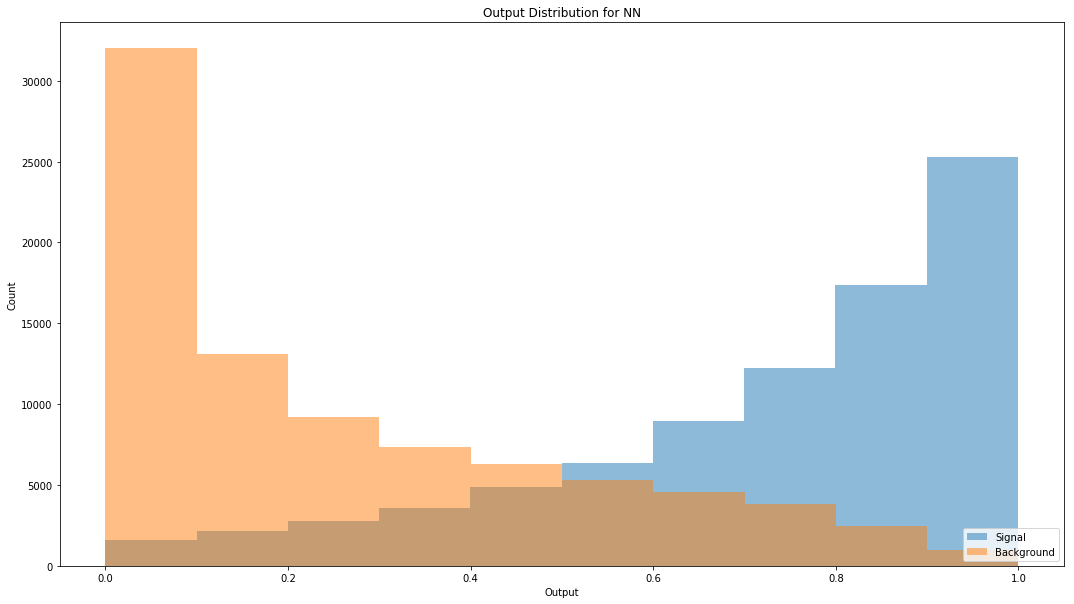

In [12]:
plot_distro([{'discriminant': discriminant,
                    'targets': nn_testy.data.numpy(),
                    'label': "All"}])

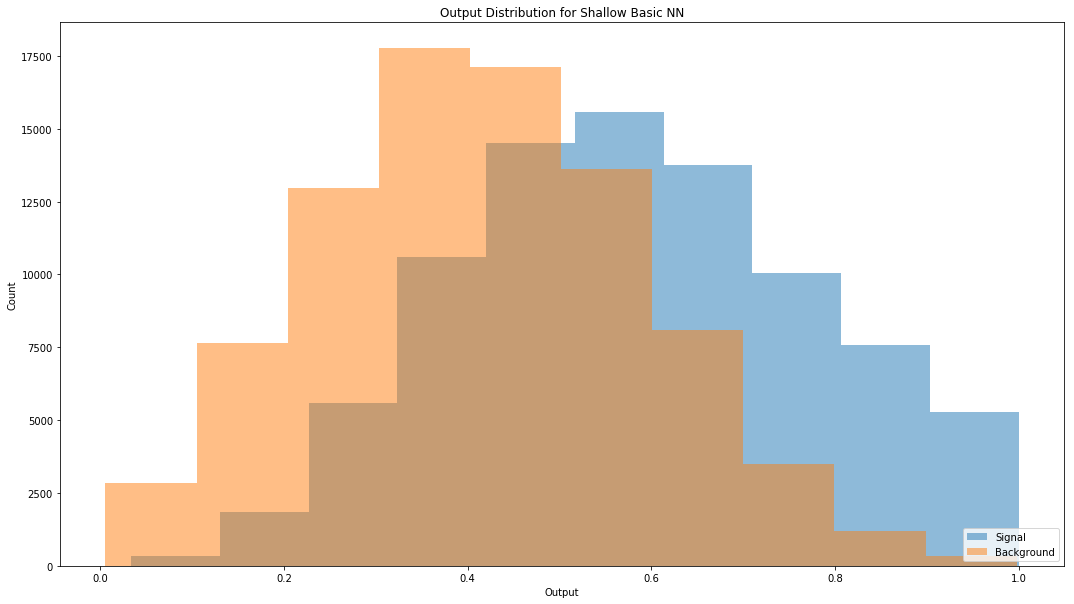

In [13]:
plot_distro([{'discriminant': raw_discriminant,
              'targets': raw_nn_testy.data.numpy(),
              'label': "Basic"}], title="Shallow Basic NN")

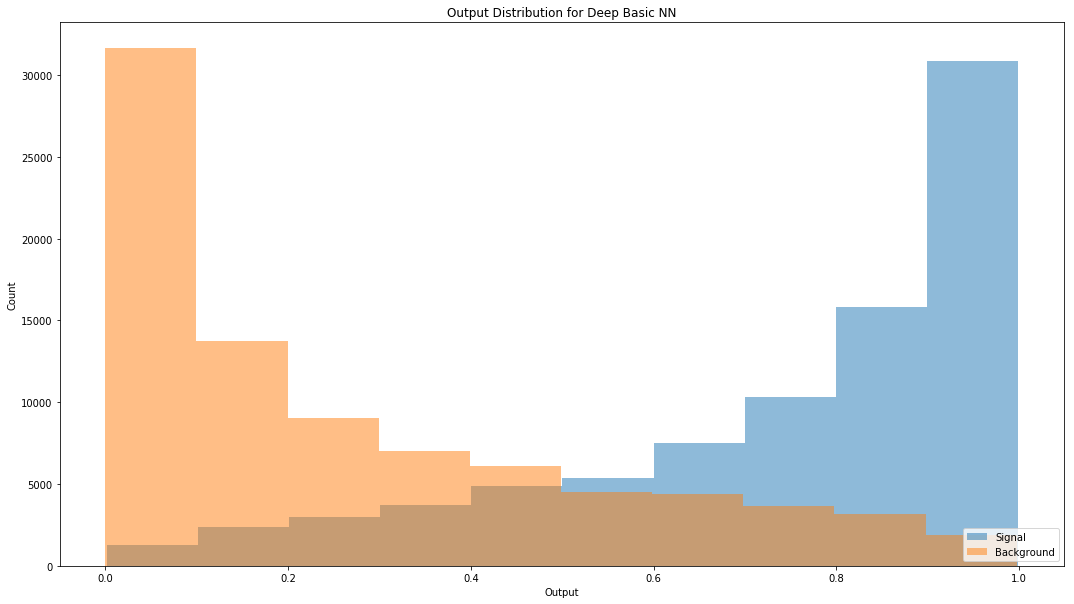

In [14]:
plot_distro([{'discriminant': deep_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Deep Basic"}], title="Deep Basic NN")

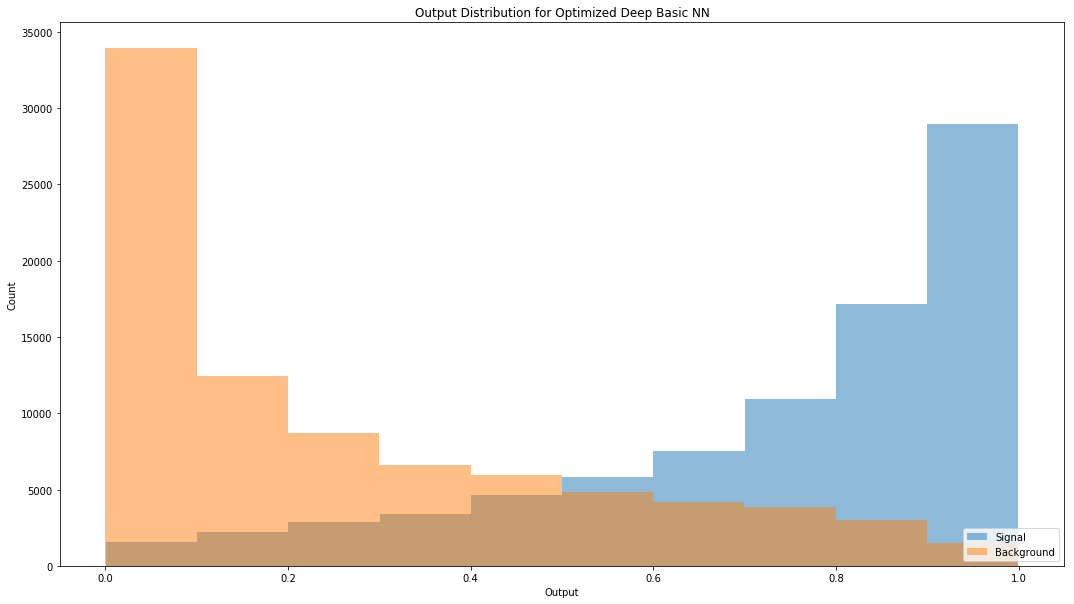

In [16]:
plot_distro([{'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="Optimized Deep Basic NN")

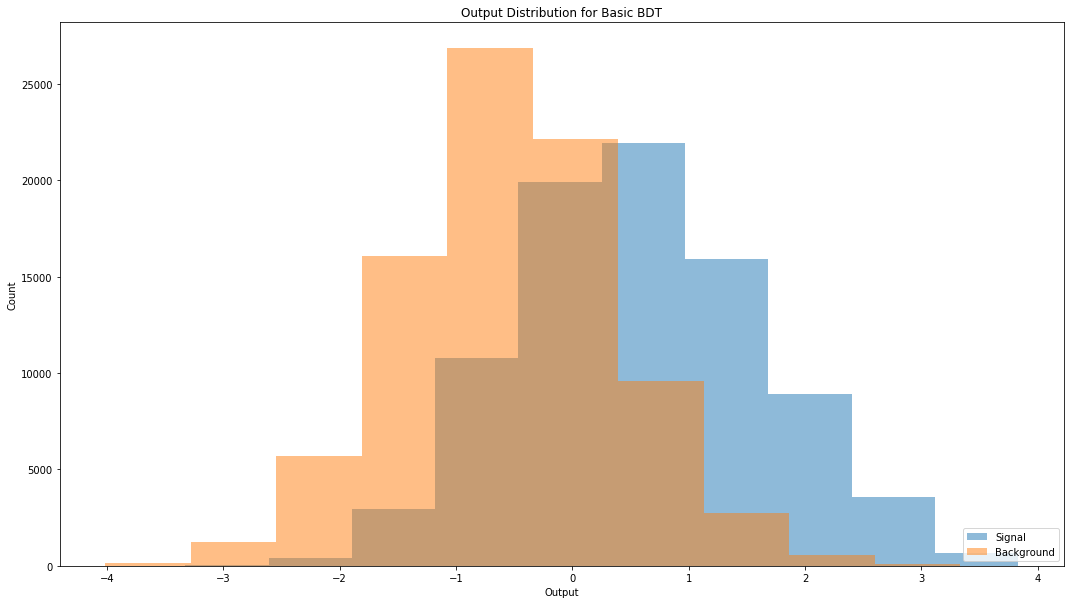

In [27]:
plot_distro([{'discriminant': bdt_basic_decision,
                     'targets': raw_test_y,
                     'label': "Basic BDT"}], title="Basic BDT")